In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from tqdm import tqdm
from itertools import combinations
from scipy.stats import ttest_ind
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None

import os

In [165]:
# %% [code]
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
np.warnings.filterwarnings('ignore')

In [3]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('25/11/2020')

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submit = pd.read_csv('sample_submission.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))
print('Размерность датасета c примером сабмишена: ', df_submit.shape)
display(df_submit.head(2))

Размерность тренировочного датасета:  (89378, 26)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100


Размерность тестового датасета:  (3837, 23)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1


Размерность датасета c примером сабмишена:  (3837, 2)


,id,price
0,0,5299000.0
1,1,1580000.0


In [7]:
# Для удобства зададим функцию, которая создаст отдельный датафрейм с этими признаками для сравнения
def check_df(df1,df2):
    '''
    Функция создает отдельный датафрейм с признаками: название,количество уникальных значений, их тип, содержание.
    А так же показывает несоответствие признаков
    '''
    ## Соберем данные по первому датасету
    list_tags_1 = list(df1.columns)
    temp_dict = {}
    temp_dict['Уникальность_1'] = df1.nunique().values
    temp_dict['Первая_строка_1'] =df1.loc[0].values
    temp_dict['тип_1'] = df1.dtypes
    temp_dict['Признак_1'] = list_tags_1
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    ## Соберем данные по второму датасету
    list_tags_2 = list(df2.columns)
    temp_dict2 = {}
    temp_dict2['Признак_2'] = list_tags_2
    temp_dict2['тип_2'] = df2.dtypes
    temp_dict2['Первая_строка_2'] =df2.loc[0].values
    temp_dict2['Уникальность_2'] = df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    ##объеденим датасеты
    temp_df = pd.concat([temp_df1,temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    display(temp_df)
    
    ## Создадим словари для сравнения данных
    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['тип_2'][i]) != str(temp_df3['тип_1'][i]):
            temp_list.append(temp_df3['Признак_1'][i])
            temp_list2.append(temp_df3['Признак_2'][i])
            temp_list3.append(str(temp_df3['тип_1'][i]) + ' != ' + str(temp_df3['тип_2'][i]))
            temp_list4.append(i)
        
    ## Создаем сравнительный датасет
    temp_dict3['index']= temp_list4
    temp_dict3['Признак_1']= temp_list
    temp_dict3['Отличие'] = temp_list3
    temp_dict3['Признак_2']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Вывод:\n 1. Не совпали типы в {len(temp_df4)} столбцах:')
    display(temp_df4)

    return

In [8]:
# сравним датасеты 
check_df(df_train, df_test)

,Уникальность_1,Первая_строка_1,тип_1,Признак_1,Признак_2,тип_2,Первая_строка_2,Уникальность_2
0,168.0,Седан,object,bodyType,bodyType,object,седан,11.0
1,36.0,AUDI,object,brand,brand,object,BMW,1.0
2,16.0,040001,object,color,color,object,чёрный,15.0
3,6.0,бензин,object,fuelType,fuelType,object,дизель,4.0
4,78.0,1990,float64,modelDate,modelDate,float64,2016,31.0
5,4484.0,2.8 MT (174 л.с.) 4WD,object,name,name,object,520d 2.0d AT (190 л.с.),384.0
6,5.0,4,float64,numberOfDoors,numberOfDoors,float64,4,4.0
7,80.0,1991,int64,productionDate,productionDate,float64,2017,37.0
8,1860.0,SEDAN MECHANICAL 2.8,object,vehicleConfiguration,vehicleConfiguration,object,SEDAN AUTOMATIC 2.0,99.0
9,4.0,MECHANICAL,object,vehicleTransmission,vehicleTransmission,object,автоматическая,3.0


Вывод:
 1. Не совпали типы в 11 столбцах:


,Признак_1,Отличие,Признак_2
index,,,
7,productionDate,int64 != float64,productionDate
11,enginePower,float64 != object,enginePower
13,mileage,int64 != float64,mileage
17,Состояние,float64 != object,Состояние
18,Владельцы,float64 != object,Владельцы
20,Таможня,bool != object,Таможня
22,price,float64 != nan,NaN
23,start_date,object != nan,NaN
24,hidden,float64 != nan,NaN


In [9]:
list_cols_to_repair = ['productionDate', 'mileage']
for col in list_cols_to_repair:
        df_train[col] = df_train[col].astype('float64')

# теперь починим int64!=float64 и приведем все к object
list_cols_to_repair = ['enginePower', 'Состояние', 'Владельцы']
for col in list_cols_to_repair:
        df_train[col] = df_train[col].astype('object')

# теперь починим bool!=object
# предварительно райдем в датасет и убедимся, что True соответсвует Растаможен зайдя на сайте (этот код тут не приводится, чтобы не нагружать ноутбук)
df_train['Таможня'] = df_train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})

In [11]:
def nunique_not_found(d_df1, d_df2, d_col):

    temp_set = set()
    temp_set2 = set()
    temp_set = set(d_df1[d_col].unique())
    temp_set2 = set(d_df2[d_col].unique())

    print(f'в столбце:= {d_col} в трейне НЕ НАЙДЕНО:= {len(temp_set2-temp_set)} уникальных значений из теста')

    return list(temp_set2-temp_set)

In [13]:
df_train['bodyType'] = df_train['bodyType'].apply(lambda x: str(x).lower())
nunique_not_found(df_train, df_test, 'bodyType')

в столбце:= bodyType в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста


[]

In [15]:
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
df_train['color'] = df_train['color'].map(dict_color)
nunique_not_found(df_train, df_test, 'color')

в столбце:= color в трейне НЕ НАЙДЕНО:= 15 уникальных значений из теста


['бежевый',
 'синий',
 'жёлтый',
 'зелёный',
 'пурпурный',
 'золотистый',
 'фиолетовый',
 'белый',
 'оранжевый',
 'чёрный',
 'коричневый',
 'серый',
 'серебристый',
 'голубой',
 'красный']

In [16]:
# vehicleTransmission - тип трасмиссии по словарю из 4 значений
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].map({'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'})


# Руль - ну тут все просто - Правый или Левый в нижнем регистре с большой буквы
df_train['Руль'] = df_train['Руль'].map({'RIGHT':'Правый', 'LEFT':'Левый'})
nunique_not_found(df_train, df_test, 'Руль')

# ПТС - тут все просто - Оригинал или Дубликат в нижнем регистре с большой буквы
df_train['ПТС'] = df_train['ПТС'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})
nunique_not_found(df_train, df_test, 'ПТС')

# Владельцы - Оригинал или Дубликат в нижнем регистре с большой буквы
df_train['Владельцы'] = df_train['Владельцы'].map({3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец'})
nunique_not_found(df_train, df_test, 'Владельцы')

# Владение - в таблице сверху в первых строках Nan поэтому нужно отдельно проверить
# оказалось что в тесте очень сложная строковая запись тогда как в трейне в значениях более структурируемые словари (УчТЕМ этот момент и разберем этот столбец на этапе анализа, вероятно будет сразу полезно создать дополнительные временные фичи) 
nunique_not_found(df_train, df_test, 'Владение');

в столбце:= Руль в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= ПТС в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= Владельцы в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= Владение в трейне НЕ НАЙДЕНО:= 157 уникальных значений из теста


In [17]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

In [18]:
# внесем данные по типам переменных из резюме в списки 
# временной ряд (1)
time_cols = ['start_date']
# бинарная переменная (0) (hidden - не включаем так как решили удалить) итого  (0+1=1)
bin_cols = []
# категориальные переменные (19), ('Таможня' - не включаем  так как решили удалить) (19+1=20)
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'name',
       'numberOfDoors', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Владение', 'model']
# числовые переменные (3) 
num_cols = ['mileage', 'modelDate', 'productionDate']
# сервисные переменные (2)
servis_cols = ['Train', 'id']
# целевая переменная (1)
target_col = ['price']

In [19]:
all_cols =cat_cols+num_cols+time_cols+servis_cols+bin_cols+ target_col
print(f'Кол-во столбцов, для дальнейшей работы после предварительного анализа:= {len(all_cols)}')

Кол-во столбцов, для дальнейшей работы после предварительного анализа:= 26


In [20]:
# берем только левый руль и тольк 26 столбцов
df = df.loc[df['Руль'] == 'Левый', all_cols]
# исключаем Руль из списка признаков для анализа итого остается 25 признаков из которых 2 сервисных (нужно проанализировать 23=25-2)
cat_cols.remove('Руль')
# удаляем дубликаты
df = df.drop_duplicates()
old_len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне:= ', old_len_train)

Кол-во строк в трейне:=  85006


In [21]:
EDA_done_cols=[]

In [22]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
print(f'Всего в тесте типов кузова:= {temp_df_Test.bodyType.nunique()}')
print(f'Всего в трейне типов кузова:= {temp_df_Train.bodyType.nunique()}')

Всего в тесте типов кузова:= 11
Всего в трейне типов кузова:= 144


In [23]:
print(f'Список 11 типов кузова БМВ из теста:= {temp_df_Test.bodyType.unique()}')
print(f'Список первых 20 из 144 типов кузова из трейна:= {temp_df_Train.bodyType.unique()[:20]}')

Список 11 типов кузова БМВ из теста:= ['седан' 'внедорожник 5 дв.' 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе'
 'родстер' 'лифтбек' 'универсал 5 дв.' 'кабриолет' 'седан 2 дв.'
 'компактвэн']
Список первых 20 из 144 типов кузова из трейна:= ['седан' 'универсал 5 дв.' 'хэтчбек 5 дв. sportback' 'хэтчбек 3 дв.'
 'хэтчбек 5 дв.' 'кабриолет' 'купе' 'лифтбек sportback' 'лифтбек'
 'седан long' 'внедорожник 5 дв.' 'кабриолет roadster' 'седан 2 дв.'
 'седан gran coupe' 'компактвэн' 'компактвэн gran tourer'
 'лифтбек gran turismo' 'хэтчбек 3 дв. compact' 'лифтбек gran coupe'
 'купе-хардтоп']


In [24]:
# оставляем только типы кузова как в тесте
list_bodyType_test = list(temp_df_Test.bodyType.unique())
df = df[df['bodyType'].isin(list_bodyType_test)]

In [25]:
def result_EDA_feature(d_feature, d_train, d_test, d_n_cols, d_EDA_done_cols, d_old_len_train):
    # записываем признак в список проанализированных признаков
    d_EDA_done_cols.append(d_feature)
    d_len_ = len(d_EDA_done_cols)
    print(f'В результате после EDA признака:= {d_feature}, обработано признаков:= {d_len_}, осталось:= {d_n_cols-d_len_}')
    # смотрим как ведет себя трейн
    temp = len(d_train)
    print('Кол-во строк в трейне:= ', temp, '. Убрали на данном шаге:= ', d_old_len_train-temp)
    d_old_len_train = temp
    # проверяем что мы случайно не испортили тест
    print('Кол-во строк в тесте:= ', len(d_test))
    return d_old_len_train, d_EDA_done_cols

In [26]:
old_len_train, EDA_done_cols = result_EDA_feature('bodyType', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= bodyType, обработано признаков:= 1, осталось:= 22
Кол-во строк в трейне:=  78734 . Убрали на данном шаге:=  6272
Кол-во строк в тесте:=  3837


In [27]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
display(temp_df_Train.enginePower[:5])
display(temp_df_Test.enginePower[:5])

0    174
1     90
2    136
3     90
4    101
Name: enginePower, dtype: object

89378    190 N12
89379    150 N12
89380    407 N12
89381    249 N12
89382    381 N12
Name: enginePower, dtype: object

In [28]:
# в тесте вытащим значение мощности перед строкой ' N12'
df.loc[df['Train']==0, 'enginePower'] = df[df['Train']==0]['enginePower'].apply(lambda x: int(x.split()[0]))

In [29]:
# переводим в int64
df['enginePower'] = df['enginePower'].astype('int64')


In [30]:
# перенесем признак в числовые
cat_cols.remove('enginePower')
num_cols.append('enginePower')

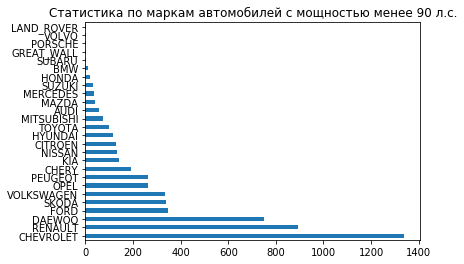

In [31]:
df[(df['Train']==1) & (df['enginePower']<90)]['brand'].value_counts().plot(kind = 'barh', title='Cтатистика по маркам автомобилей с мощностью менее 90 л.с.')

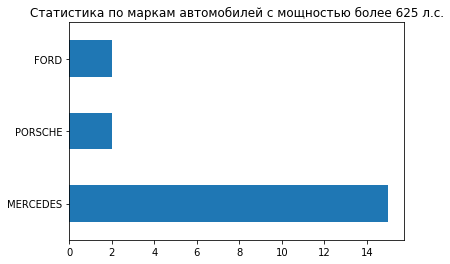

In [32]:
df[(df['Train']==1) & (df['enginePower']>625)]['brand'].value_counts().plot(kind = 'barh', title='Cтатистика по маркам автомобилей с мощностью более 625 л.с.')

In [33]:
df=df[(df['enginePower']<=625) & (df['enginePower']>=90)]

In [35]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = result_EDA_feature('enginePower', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= enginePower, обработано признаков:= 2, осталось:= 21
Кол-во строк в трейне:=  73089 . Убрали на данном шаге:=  5645
Кол-во строк в тесте:=  3837


In [36]:
def hbar_group_pivot_table(d_bodyType, 
                        d_group_col, 
                        d_df, 
                        d_year_start, 
                        d_year_end,
                        d_my_font_scale):
    temp_df = d_df.copy()
    temp_df2 = temp_df[(temp_df['bodyType']==d_bodyType) & (temp_df['modelDate']>=d_year_start) & (temp_df['modelDate']<=d_year_end)]
    

    temp_pt_mean = pd.pivot_table(temp_df2, values =d_group_col, index =['bodyType','brand'], columns =['modelDate'],aggfunc = np.mean, margins=True)
    temp_list = list(temp_pt_mean['All'][d_bodyType].index)

    temp_pt_std = pd.pivot_table(temp_df2, values =d_group_col, index =['bodyType','brand'], columns =['modelDate'],aggfunc = np.std, margins=True)
    temp_std = temp_pt_std['All'][d_bodyType]['BMW']
    temp_mean = temp_pt_mean['All'][d_bodyType]['BMW']
    a = temp_pt_mean['All'][d_bodyType]['BMW']-temp_std/2
    b = temp_pt_mean['All'][d_bodyType]['BMW']+temp_std/2

    temp_list2 = list(temp_pt_std['All'][d_bodyType].index)

    temp_list_std =[]
    list_overlapp_brands =[]
    for brand in temp_list:
        if brand in temp_list2:
            std_ = temp_pt_std['All'][d_bodyType][brand]/2
        else:
            std_ = 0
        temp_list_std.append(std_)
        c = temp_pt_mean['All'][d_bodyType][brand] - std_
        d = temp_pt_mean['All'][d_bodyType][brand] + std_
        if brand != 'BMW' and ((b>=c and d>=a) or (a<=c and d<=b)):
            list_overlapp_brands.append(brand)
    
    temp_std = temp_pt_std['All'][d_bodyType]['BMW']
    temp_mean = temp_pt_mean['All'][d_bodyType]['BMW']

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)
    color_bar = plt.get_cmap('PuBu')(0.8)

    plt.figure(figsize=(12, 6))
    
    plt.barh(temp_list, width=temp_pt_mean['All'][d_bodyType].values+temp_list_std, color =color_bar)
    plt.barh(temp_list, width=temp_pt_mean['All'][d_bodyType].values, color ='red')
    plt.barh(temp_list, width=temp_pt_mean['All'][d_bodyType].values-temp_list_std, color =color_bar)


    plt.plot([temp_mean,temp_mean], [-1, len(temp_list)+1], color= 'red', label='среднее значение BMW', marker='.', lw=2, ls = '--')
    plt.plot([temp_mean-temp_std/2,temp_mean-temp_std/2], [-1, len(temp_list)+1], color='grey', label='отклонение вниз на std/2', marker='.', lw=3)
    plt.plot([temp_mean+temp_std/2,temp_mean+temp_std/2], [-1, len(temp_list)+1], color='blue', label='отклонение вверх на std/2', marker='.', lw=3)

    plt.xlabel(d_group_col, fontsize=15, color = color_text)
    plt.ylabel('brand', fontsize=15, color = color_text)
    plt.title(f'Среднее и отклонение {d_group_col} сводной таблицы сгруппированной по {d_bodyType}. modelDate с {d_year_start} по {d_year_end}', color = color_text, fontsize=15)
    plt.legend(loc="lower right", fontsize=11)
    # y_min_text = y_min +0.5*max(std_metric_train,std_metric_test)
    plt.text(100, len(temp_list)-0.5, f'кол-во брендов авто попавших в сводную таблицу = {len(temp_list)} из 36 \nкол-во брендов авто попадающих в область значений BMW = {len(list_overlapp_brands)} из 36', fontsize = 14)
    plt.show()
    print('Список релевантных брендов: ',*list_overlapp_brands)
    return list_overlapp_brands

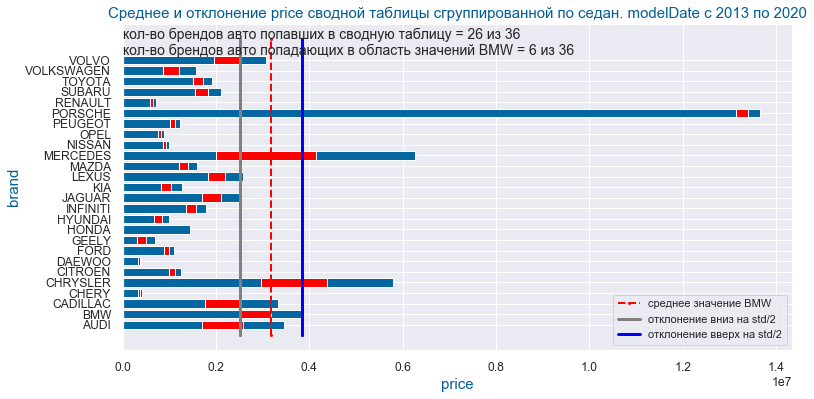

Список релевантных брендов:  AUDI CADILLAC CHRYSLER LEXUS MERCEDES VOLVO


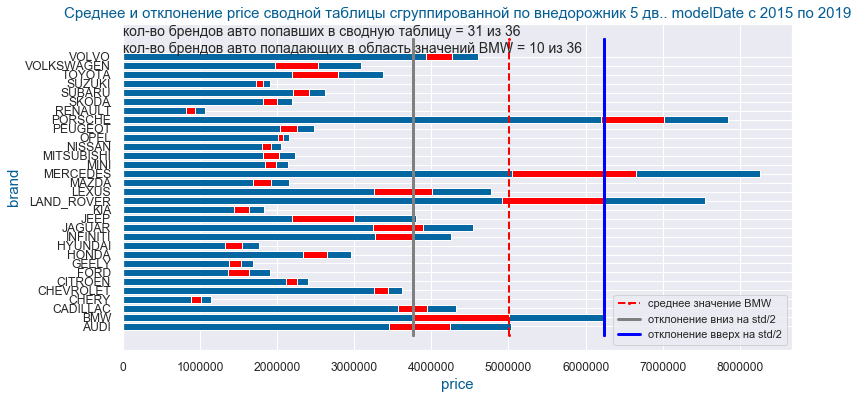

Список релевантных брендов:  AUDI CADILLAC INFINITI JAGUAR JEEP LAND_ROVER LEXUS MERCEDES PORSCHE VOLVO


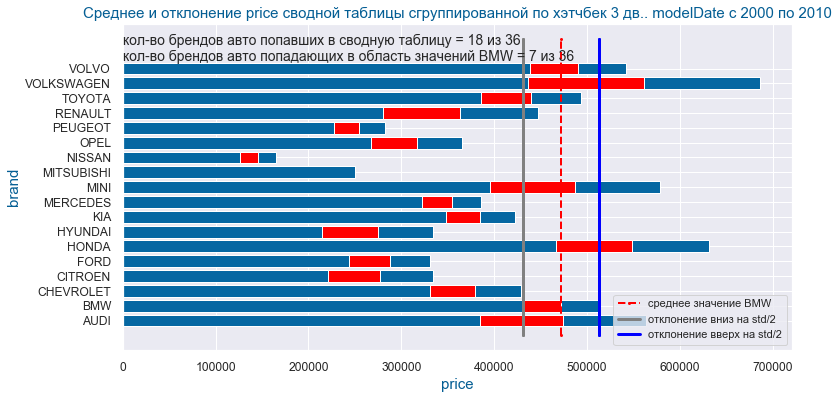

Список релевантных брендов:  AUDI HONDA MINI RENAULT TOYOTA VOLKSWAGEN VOLVO


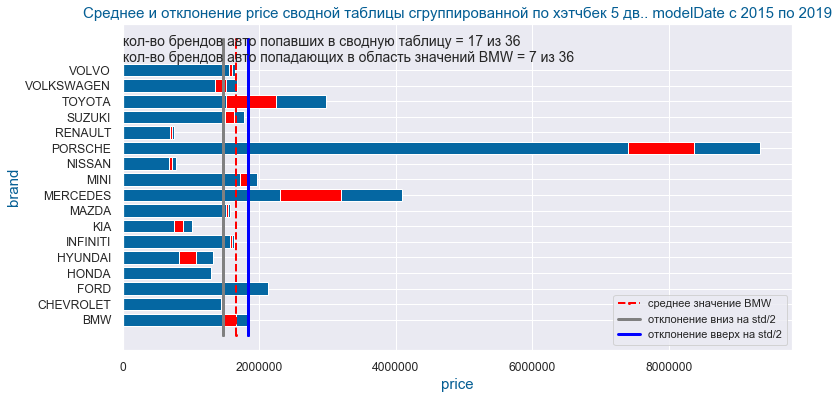

Список релевантных брендов:  INFINITI MAZDA MINI SUZUKI TOYOTA VOLKSWAGEN VOLVO


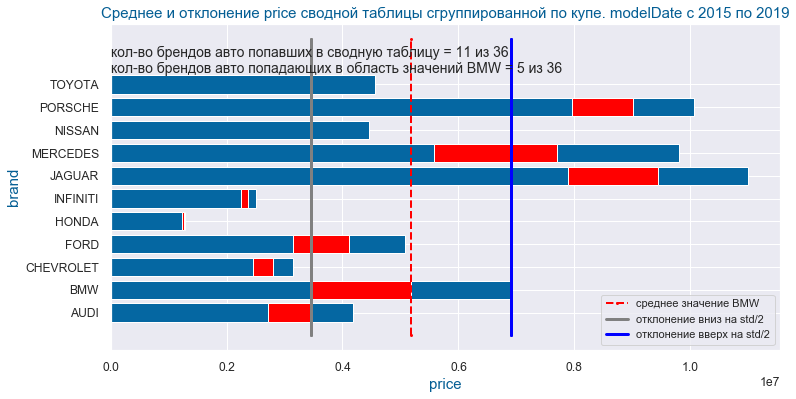

Список релевантных брендов:  AUDI FORD MERCEDES NISSAN TOYOTA


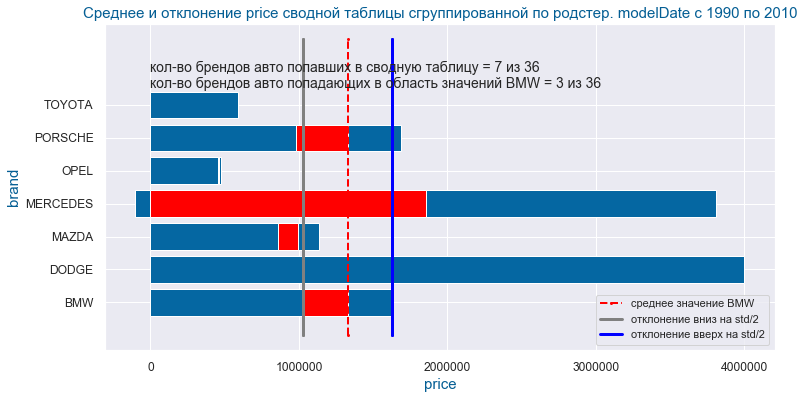

Список релевантных брендов:  MAZDA MERCEDES PORSCHE


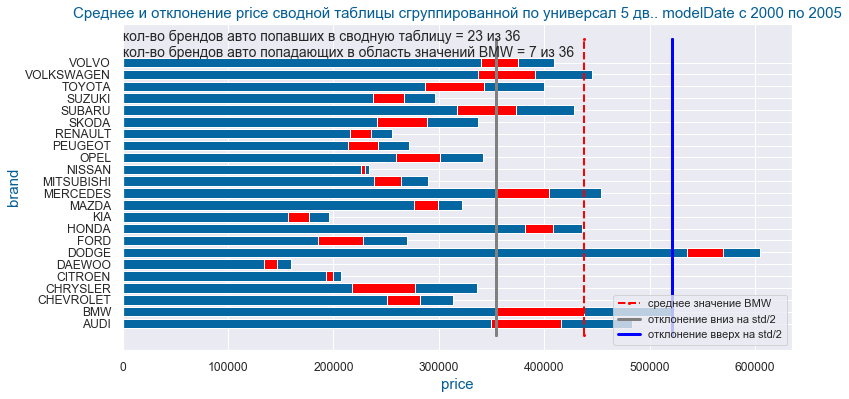

Список релевантных брендов:  AUDI HONDA MERCEDES SUBARU TOYOTA VOLKSWAGEN VOLVO


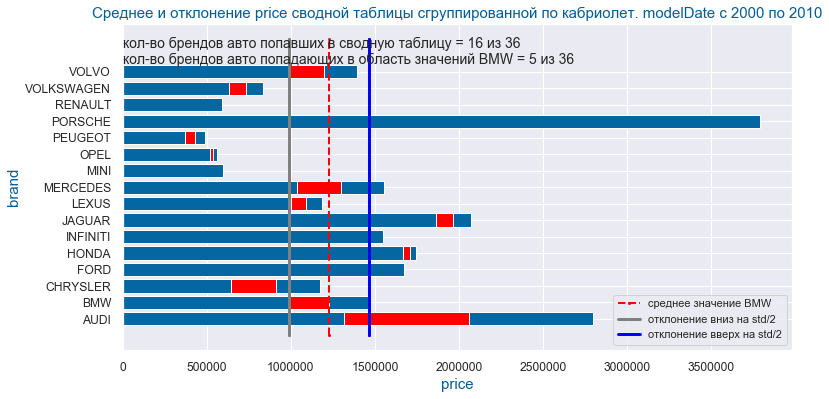

Список релевантных брендов:  AUDI CHRYSLER LEXUS MERCEDES VOLVO


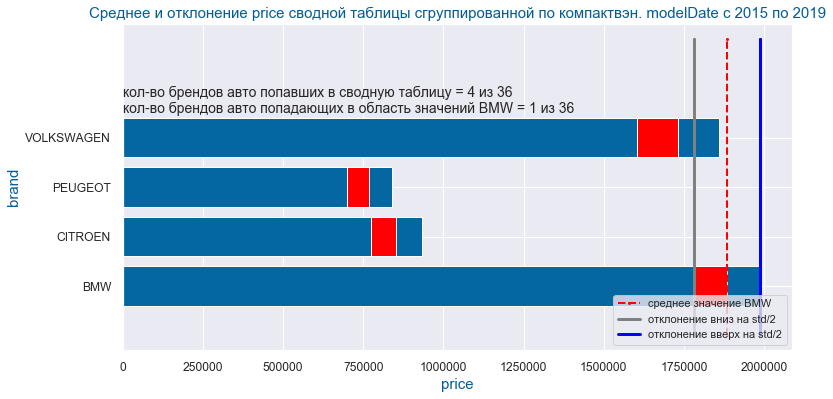

Список релевантных брендов:  VOLKSWAGEN


In [39]:
import seaborn as sns
list_brand0 = hbar_group_pivot_table(list_bodyType_test[0], 'price', df[df['Train']==1], 2013, 2020, 1.1)
list_brand1 = hbar_group_pivot_table(list_bodyType_test[1], 'price', df[df['Train']==1], 2015, 2019, 1.1)
list_brand2 = hbar_group_pivot_table(list_bodyType_test[2], 'price', df[df['Train']==1], 2000, 2010, 1.1)
list_brand3 = hbar_group_pivot_table(list_bodyType_test[3], 'price', df[df['Train']==1], 2015, 2019, 1.1)
list_brand4 = hbar_group_pivot_table(list_bodyType_test[4], 'price', df[df['Train']==1], 2015, 2019, 1.1)
list_brand5 = hbar_group_pivot_table(list_bodyType_test[5], 'price', df[df['Train']==1], 1990, 2010, 1.1)
list_brand7 = hbar_group_pivot_table(list_bodyType_test[7], 'price', df[df['Train']==1], 2000, 2005, 1.1)
list_brand8 = hbar_group_pivot_table(list_bodyType_test[8], 'price', df[df['Train']==1], 2000, 2010, 1.1)
list_brand10 = hbar_group_pivot_table(list_bodyType_test[10], 'price', df[df['Train']==1], 2015, 2019, 1.1)

In [40]:
list_final_brand = list(set(list_brand0+list_brand1+list_brand2+list_brand3 +
                            list_brand4+list_brand5+list_brand7+list_brand8+list_brand10))

In [41]:
# оставляем 22 релевантных (21+BMW) бренд авто, остальные удаляем
df = df[df['brand'].isin(list_final_brand+['BMW'])]

In [43]:
old_len_train, EDA_done_cols = result_EDA_feature('brand', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= brand, обработано признаков:= 3, осталось:= 20
Кол-во строк в трейне:=  48338 . Убрали на данном шаге:=  24751
Кол-во строк в тесте:=  3837


In [45]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
print(f'Список зачений по fuelType в трейне:= {list(temp_df_Train.fuelType.unique())}')
print(f'Список зачений по fuelType в тесте:= {list(temp_df_Test.fuelType.unique())}')
list_fuelType_test = temp_df_Test.fuelType.unique()
df = df[df['fuelType'].isin(list_fuelType_test)]

Список зачений по fuelType в трейне:= ['бензин', 'дизель', 'электро', 'гибрид']
Список зачений по fuelType в тесте:= ['дизель', 'бензин', 'гибрид', 'электро']


In [47]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = result_EDA_feature('fuelType', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= fuelType, обработано признаков:= 4, осталось:= 19
Кол-во строк в трейне:=  48328 . Убрали на данном шаге:=  10
Кол-во строк в тесте:=  3837


In [48]:
# обработаем значения с помощью регулярных выражений найдя значения объема в литра типа 2.0 и переведем их см3 
def engineDisplacement_to_float(row):
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return int(float(volume[0])*1000)
# поле engineDisplacement заполненно не полностью именно мощностью, в отличии от поля name
# поэтому вытаскиваем мощность из поля name
df['engineDisplacement2'] = df['name'].apply(engineDisplacement_to_float)
# посмотрим сколько пропусков
len(df[df['engineDisplacement2'].isna()])

67

In [50]:
temp_df = temp_df_Train[(temp_df_Train['bodyType']==list_bodyType_test[3]) & (temp_df_Train['brand']=='BMW') & (temp_df_Train['modelDate']>=2013) & (temp_df_Train['modelDate']<=2017)& (temp_df_Train['price']>=1657314) & (temp_df_Train['modelDate']<=2377624)& (temp_df_Train['enginePower']>=170-10) & (temp_df_Train['enginePower']<=170+10)& (temp_df_Train['fuelType']!='электро')]
display(temp_df.head(2))
display(temp_df.describe())

,bodyType,brand,color,fuelType,name,numberOfDoors,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Владение,model,mileage,modelDate,productionDate,start_date,Train,id,price
8254,хэтчбек 5 дв.,BMW,NaN,гибрид,94Ah 0.7hyb AT (170 л.с.),5.0,HATCHBACK_5_DOORS AUTOMATIC 94Ah,автоматическая,94Ah,170,2017 год (выпущен в сентябре 2017 года) \n94 A...,{'id': '0'},задний,Левый,NaN,1 владелец,Оригинал,"{'year': 2020, 'month': 4}",I3,23000.0,2013.0,2017.0,2020-08-30T20:10:49Z,1,NaN,2331000.0
8255,хэтчбек 5 дв.,BMW,NaN,гибрид,94Ah 0.7hyb AT (170 л.с.),5.0,HATCHBACK_5_DOORS AUTOMATIC 94Ah,автоматическая,94Ah,170,NaN,{'id': '0'},задний,Левый,NaN,1 владелец,Оригинал,NaN,I3,27000.0,2013.0,2017.0,2020-08-30T08:35:06Z,1,NaN,1840000.0


,numberOfDoors,enginePower,mileage,modelDate,productionDate,Train,id,price
count,8.0,8.0,8.000000,8.00000,8.000000,8.0,0.0,8.000000e+00
mean,5.0,170.0,35856.125000,2014.00000,2016.625000,1.0,NaN,2.008125e+06
std,0.0,0.0,13522.039897,1.85164,1.407886,0.0,NaN,2.436505e+05
min,5.0,170.0,17000.000000,2013.00000,2014.000000,1.0,NaN,1.699000e+06
25%,5.0,170.0,26000.000000,2013.00000,2016.500000,1.0,NaN,1.830000e+06
50%,5.0,170.0,35797.500000,2013.00000,2017.000000,1.0,NaN,1.932500e+06
75%,5.0,170.0,44313.500000,2014.00000,2017.250000,1.0,NaN,2.257500e+06
max,5.0,170.0,57000.000000,2017.00000,2018.000000,1.0,NaN,2.331000e+06


In [51]:
df['engineDisplacement2'].fillna(700, inplace = True)

In [52]:
cat_cols.remove('engineDisplacement') 
num_cols.append('engineDisplacement2')

In [53]:
df = df[df['engineDisplacement2']!=0]

In [54]:
df = df[df['engineDisplacement2']<=6600]

In [55]:
df['engineDisplacement2_log'] = np.log(df['engineDisplacement2'] + 1)
num_cols.append('engineDisplacement2_log')

In [57]:
old_len_train, EDA_done_cols = result_EDA_feature('engineDisplacement', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= engineDisplacement, обработано признаков:= 5, осталось:= 18
Кол-во строк в трейне:=  48317 . Убрали на данном шаге:=  11
Кол-во строк в тесте:=  3837


In [58]:
df['numberOfDoors'] = df['numberOfDoors'].astype('int64')

In [ ]:
cat_cols.remove('numberOfDoors')
num_cols.append('numberOfDoors')

In [62]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = result_EDA_feature('numberOfDoors', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= numberOfDoors, обработано признаков:= 6, осталось:= 17
Кол-во строк в трейне:=  48317 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [63]:
# переведем в int64 критерий numberOfDoors
df['mileage'] = df['mileage'].astype('int64')

In [64]:
# это полпроцента от объема теста удаляем все пробеги выше 432000 в трейне
df = df[((df['Train']==1) & (df['mileage']<=432000)) | ((df['Train']==0))]

In [66]:
old_len_train, EDA_done_cols = result_EDA_feature('mileage', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)


В результате после EDA признака:= mileage, обработано признаков:= 7, осталось:= 16
Кол-во строк в трейне:=  47871 . Убрали на данном шаге:=  446
Кол-во строк в тесте:=  3837


In [67]:
df.loc[:, 'Владельцы'] = df['Владельцы'].apply(lambda x: int(x.split()[0]) if type(x)==str else None)

In [68]:
df['Владельцы'].fillna(0.0, inplace=True)

In [69]:
cat_cols.remove('Владельцы')
num_cols.append('Владельцы')

In [71]:
old_len_train, EDA_done_cols = result_EDA_feature('Владельцы', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Владельцы, обработано признаков:= 8, осталось:= 15
Кол-во строк в трейне:=  47871 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [72]:
df = df[((df['Train']==1)&(df['price'].isna()==False)) | (df['Train']==0)]

In [73]:
df = df[((df['Train']==1) & (df['price']>=60000) & (df['price']<1.47812e+07)) | (df['Train']==0)]

In [74]:
# ну теперь получилось очень красивое логнормальное распределение, хотя конечно необходимо было сначала проверить гипотезу о нормальном распределении, мы этот момент опустили из-за нехватки времени, просто создаем новый признак price_log логарифм от цены
df['price_log']=df['price'].apply(lambda x: np.log(x))

In [75]:
target_col.append('price_log')

In [77]:
old_len_train, EDA_done_cols = result_EDA_feature('price', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= price, обработано признаков:= 9, осталось:= 14
Кол-во строк в трейне:=  47398 . Убрали на данном шаге:=  473
Кол-во строк в тесте:=  3837


In [78]:
# их немного 38 удаляем точно, а что с марками датой выпуска 2020
df[(df['Train']==1) & (df['modelDate']==2020)].brand.value_counts()

MERCEDES      252
VOLKSWAGEN    248
BMW           174
RENAULT        21
MINI            8
VOLVO           2
Name: brand, dtype: int64

In [81]:
df = df[((df['Train']==1) & (df['modelDate']>=1975) & (df['modelDate']<=2019)) | (df['Train']==0)]

In [82]:
old_len_train, EDA_done_cols = result_EDA_feature('modelDate', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= modelDate, обработано признаков:= 11, осталось:= 12
Кол-во строк в трейне:=  46655 . Убрали на данном шаге:=  743
Кол-во строк в тесте:=  3837


In [83]:
df = df[((df['Train']==1) & (df['productionDate']>=1981) & (df['productionDate']<=2019)) | (df['Train']==0)]

In [84]:
current_year = 2020
df['intensity']=df['mileage']/(current_year-df['productionDate'])
df['dateModelProdDiff']=df['productionDate']-df['modelDate']

# добавляем новые признаки
num_cols.append('intensity')
num_cols.append('dateModelProdDiff')

In [86]:
df['rarity']=(df['intensity']<5000)&(df['productionDate']<1990)
# добавляем новые признаки
bin_cols.append('rarity')

In [87]:
df['pDate_more_2015']=df['productionDate']>=2015
df['pDate_more_2005']=(df['productionDate']>=2005)&(df['productionDate']<2015)
df['pDate_more_1990']=(df['productionDate']>=1990)&(df['productionDate']<2005)
df['pDate_less_1990']=(df['productionDate']<1990)

# добавляем новые признаки
bin_cols.append('pDate_more_2015')
bin_cols.append('pDate_more_2005')
bin_cols.append('pDate_more_1990')
bin_cols.append('pDate_less_1990')

In [89]:
old_len_train, EDA_done_cols = result_EDA_feature('productionDate', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= productionDate, обработано признаков:= 12, осталось:= 11
Кол-во строк в трейне:=  39372 . Убрали на данном шаге:=  7283
Кол-во строк в тесте:=  3837


In [90]:
# удаляем
cat_cols.remove('vehicleConfiguration')

In [92]:
old_len_train, EDA_done_cols = result_EDA_feature('vehicleConfiguration', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= vehicleConfiguration, обработано признаков:= 13, осталось:= 10
Кол-во строк в трейне:=  39372 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [93]:
# удалим вариатор
df = df[((df['Train']==1) & (df['vehicleTransmission']!='вариатор')) | (df['Train']==0)]


In [95]:
old_len_train, EDA_done_cols = result_EDA_feature('vehicleTransmission', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= vehicleTransmission, обработано признаков:= 14, осталось:= 9
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  3574
Кол-во строк в тесте:=  3837


In [96]:
cat_cols.remove('Комплектация')

In [97]:
old_len_train, EDA_done_cols = result_EDA_feature('Комплектация', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Комплектация, обработано признаков:= 15, осталось:= 8
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [100]:
# заполним пропуски
df['description'] = df['description'].fillna('[]')

# запишем списки слов в описании в отдельный столбец
df['words_in_description'] = df['description'].apply(lambda x: [str(i).lower() for i in x.split()])

In [101]:

df['count_words_d'] = df['description'].apply(lambda x: len(x.split()))

vectorizer = CountVectorizer()
text_feat = vectorizer.fit_transform(df['description'])

# создаем новые признаки кол-во среднее кол-во токенов и их сумма в описании
df['mean_c_w'] = text_feat.mean(axis=1)
df['sum_c_w'] = text_feat.sum(axis=1)

# удаляем 'description'
cat_cols.remove('description')

# добавляем 'count_words_d', 'mean_c_w', 'sum_c_w'
num_cols.append('count_words_d')
num_cols.append('mean_c_w')
num_cols.append('sum_c_w')

ValueError: list.remove(x): x not in list

In [ ]:
df['c_p_des1']= df['words_in_description'].apply(lambda x: 1 if ('защита' and 'картера') in x else 0)
bin_cols.append('c_p_des1')

# мультифункциональный руль - multifunction steering wheel
df['m_s_w_des2']= df['words_in_description'].apply(lambda x: 1 if ('мультифункциональный' and 'руль') in x else 0)
bin_cols.append('m_s_w_des2')

# датчики дождя и света - rain and light sensors
df['r_l_s_des3']= df['words_in_description'].apply(lambda x: 1 if ('датчики' and 'дождя' and 'света') in x else 0)
bin_cols.append('r_l_s_des3')

# АБС
df['abs_des4']= df['words_in_description'].apply(lambda x: 1 if ('антиблокировочная' and 'система') in x else 0)
bin_cols.append('abs_des4')

# круиз контроль - cruise control
df['c_c_des5']= df['words_in_description'].apply(lambda x: 1 if ('круиз-контроль') in x else 0)
bin_cols.append('c_c_des5')

# легкосплавные диски - alloy wheels
df['a_w_des6']= df['words_in_description'].apply(lambda x: 1 if ('легкосплавные' and 'диски') in x else 0)
bin_cols.append('a_w_des6')

# камера заднего вида - rear view camera
df['r_v_c_des7']= df['words_in_description'].apply(lambda x: 1 if ('камера' and 'видеокамера') in x else 0)
bin_cols.append('r_v_c_des7')

In [103]:
old_len_train, EDA_done_cols = result_EDA_feature('description', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= description, обработано признаков:= 16, осталось:= 7
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [105]:
old_len_train, EDA_done_cols = result_EDA_feature('Привод', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Привод, обработано признаков:= 17, осталось:= 6
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [106]:
# удалим Состояние потому что не понятно как его обработать
cat_cols.remove('Состояние')

In [108]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = result_EDA_feature('Состояние', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Состояние, обработано признаков:= 18, осталось:= 5
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [109]:
df['ПТС'].fillna('Нет', inplace = True)

In [111]:
old_len_train, EDA_done_cols = result_EDA_feature('ПТС', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)


В результате после EDA признака:= ПТС, обработано признаков:= 19, осталось:= 4
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [114]:
cat_cols.remove('Владение')
old_len_train, EDA_done_cols = result_EDA_feature('Владение', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Владение, обработано признаков:= 20, осталось:= 3
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [115]:
# добавим что-то напоминающее модель в категориальные признаки 
df['model2'] = df['name'].apply(lambda x: str(x).split()[0])
cat_cols.append('model2')
# добавим что-то напоминающее характеристику модели в категориальные признаки 
df['model2_2'] = df['name'].apply(lambda x: str(x).split()[1])
cat_cols.append('model2_2')

In [116]:
old_len_train, EDA_done_cols = result_EDA_feature('name', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= name, обработано признаков:= 21, осталось:= 2
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [118]:
#приведем числовые критерии к int64 для CatBoost
for col in ['modelDate', 'productionDate', 'engineDisplacement2']:
    df[col] = df[col].astype('int64')
# позволяет закрепить random_state во всей ячейке исполнения
np.random.seed(42)

le = LabelEncoder()

le.fit(df['bodyType'])
df['bodyType_'] = le.transform(df['bodyType'])

le.fit(df['name'])
df['name_'] = le.transform(df['name'])

le.fit(df['model2'])
df['model2_'] = le.transform(df['model2'])

le.fit(df['model2_2'])
df['model2_2_'] = le.transform(df['model2_2'])

le.fit(df['Привод'])
df['Привод_'] = le.transform(df['Привод'])

le.fit(df['fuelType'])
df['fuelType_'] = le.transform(df['fuelType'])

le.fit(df['vehicleTransmission'])
df['vehicleTransmission_'] = le.transform(df['vehicleTransmission'])

le.fit( df[df['Train']==1]['model'])
df.loc[df['Train']==1, 'model_'] = le.transform(df[df['Train']==1]['model'])
# выведем соответсвия номеров в model_ и моделей БМВ
temp_train = df[(df['Train']==1) & (df['brand']=='BMW')]
list_model = list(temp_train.model_.unique())

In [119]:
cols_for_CatBoost = ['bodyType_', 'name_', 'model2_', 'model2_2_', 'modelDate', 'engineDisplacement2', 'Привод_', 'fuelType_', 'enginePower', 'vehicleTransmission_']

In [120]:
temp_train = df[(df['Train']==1) & (df['brand']=='BMW')]
temp_test = df[(df['Train']==0)]
train_data = temp_train[cols_for_CatBoost] # обучающая выборка
train_labels = temp_train['model_'] # метки принадлежности к классу
test_data = temp_test[cols_for_CatBoost] # тестовая выборка

model = CatBoostClassifier(iterations=50, learning_rate = 0.5, random_state=RANDOM_SEED) # классификатор
model.fit(train_data, train_labels) # обучение классификатора
prediction = model.predict(test_data) # передача тестовой выборки в модель
print(*list(prediction[:10])) # вывод результата "предсказания"

0:	learn: 1.2125625	total: 165ms	remaining: 8.06s
1:	learn: 1.4764947	total: 192ms	remaining: 4.61s
2:	learn: 1.0448103	total: 219ms	remaining: 3.44s
3:	learn: 0.5596550	total: 246ms	remaining: 2.83s
4:	learn: 0.3877922	total: 276ms	remaining: 2.49s
5:	learn: 0.3417192	total: 302ms	remaining: 2.22s
6:	learn: 0.3135431	total: 330ms	remaining: 2.03s
7:	learn: 0.2704794	total: 357ms	remaining: 1.87s
8:	learn: 0.2461714	total: 387ms	remaining: 1.76s
9:	learn: 0.2325654	total: 412ms	remaining: 1.65s
10:	learn: 0.2017442	total: 439ms	remaining: 1.55s
11:	learn: 0.1905056	total: 465ms	remaining: 1.47s
12:	learn: 0.1775517	total: 492ms	remaining: 1.4s
13:	learn: 0.1710551	total: 518ms	remaining: 1.33s
14:	learn: 0.1660887	total: 545ms	remaining: 1.27s
15:	learn: 0.1432457	total: 573ms	remaining: 1.22s
16:	learn: 0.1377974	total: 599ms	remaining: 1.16s
17:	learn: 0.1353145	total: 627ms	remaining: 1.11s
18:	learn: 0.1138905	total: 655ms	remaining: 1.07s
19:	learn: 0.1104990	total: 683ms	remainin

In [121]:
# проверим первые 10 элементов теста
temp_test[['brand','bodyType', 'name', 'model', 'model2', 'modelDate', 'engineDisplacement2', 'Привод', 'fuelType', 'enginePower', 'vehicleTransmission']][:10]

,brand,bodyType,name,model,model2,modelDate,engineDisplacement2,Привод,fuelType,enginePower,vehicleTransmission
89378,BMW,седан,520d 2.0d AT (190 л.с.),NaN,520d,2016,2000,задний,дизель,190,автоматическая
89379,BMW,седан,318d 2.0d AT (150 л.с.),NaN,318d,2018,2000,задний,дизель,150,автоматическая
89380,BMW,седан,550i xDrive 4.4 AT (407 л.с.) 4WD,NaN,550i,2009,4400,полный,бензин,407,автоматическая
89381,BMW,внедорожник 5 дв.,30d 3.0d AT (249 л.с.) 4WD,NaN,30d,2014,3000,полный,дизель,249,автоматическая
89382,BMW,внедорожник 5 дв.,M50d 3.0d AT (381 л.с.) 4WD,NaN,M50d,2014,3000,полный,дизель,381,автоматическая
89383,BMW,внедорожник 5 дв.,30d 3.0d AT (249 л.с.) 4WD,NaN,30d,2013,3000,полный,дизель,249,автоматическая
89384,BMW,внедорожник 5 дв.,28i xDrive 2.0 AT (245 л.с.) 4WD,NaN,28i,2010,2000,полный,бензин,245,автоматическая
89385,BMW,внедорожник 5 дв.,20d 2.0d AT (177 л.с.) 4WD,NaN,20d,2006,2000,полный,дизель,177,автоматическая
89386,BMW,внедорожник 5 дв.,30d 3.0d AT (245 л.с.) 4WD,NaN,30d,2010,3000,полный,дизель,245,автоматическая
89387,BMW,седан,520i 2.0 AT (184 л.с.),NaN,520i,2013,2000,задний,бензин,184,автоматическая


In [122]:
df.loc[df['Train']==0, 'model_']=prediction

In [123]:
# больше name нам не нужно удалим его
cat_cols.remove('name')
# также удалим model потому что теперьу нас есть числовой признак модели model_
cat_cols.remove('model')
# добавим новый признак
cat_cols.append('model_')

In [124]:
# сохраним список номеров всех моделей BMW
list_all_num_model_BMW = df[df['brand']=='BMW'].model_.unique()

In [126]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = result_EDA_feature('model', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= model, обработано признаков:= 22, осталось:= 1
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [127]:
time_cols.remove('start_date')

In [128]:
old_len_train, EDA_done_cols = result_EDA_feature('start_date', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= start_date, обработано признаков:= 23, осталось:= 0
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [129]:
# записываем признак в список проанализированных признаков
EDA_done_cols.append('color')
old_len_train, EDA_done_cols = result_EDA_feature('', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= , обработано признаков:= 25, осталось:= -2
Кол-во строк в трейне:=  35798 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


In [130]:
# сохраняем все переменные из списков
all_cols_df3 =cat_cols+num_cols+time_cols+servis_cols+bin_cols+target_col
# образаем исходный датасет только переменными, которые мы решили оставить
df3 = df.loc[:, all_cols_df3].copy()

In [131]:
def simple_heatmap(d_title, d_df, d_list_of_columns, d_my_font_scale, d_g, d_size):
    """
    
    """
    temp_df = d_df[d_list_of_columns].copy()

    plt.style.use('seaborn-paper')
    plt.subplots(figsize=(d_size, 6))
    color_text = plt.get_cmap('PuBu')(0.85)
    sns.set(font_scale=d_my_font_scale, style='whitegrid')

    plt.subplot(111)
    h = sns.heatmap(temp_df.corr(), annot = True, fmt=f'.{d_g}g', cmap= "PuBu", center= 0)
    h.set_title(d_title,  fontsize=14, color = color_text)

    return

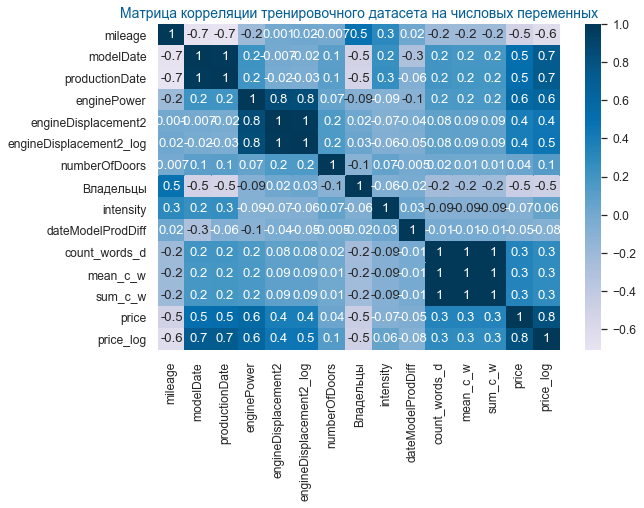

In [132]:
simple_heatmap('Матрица корреляции тренировочного датасета на числовых переменных',df3[df3['Train']==1], num_cols+target_col, 1.1, 1, 9)

In [133]:
temp_df = df3[df3['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['price_log'])[0], index = num_cols)

In [134]:
# переведем категориальные признаки в dummies переменные
# но сначала сохраним список переменных чтобы можно было сделать список добавленных
list_cols_bef_dumm = list(df3.columns)

# а также мы хотим преобразовать числовые признаки 'Владельцы' и 'engineDisplacement2'
# поэтому сохраним их дубликаты
arr_Владельцы = np.array(df3['Владельцы'])

# преобразуем переменные в дамми переменные
df3 = pd.get_dummies(df3, columns = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Владельцы', 'ПТС', 'model_', 'engineDisplacement2'])

# вернем владельцев
df3['Владельцы'] = arr_Владельцы 

# теперь создадим список дамми переменных
list_cols_aft_dumm = list(df3.columns)
dumm_cols= list(set(list_cols_aft_dumm)-set(list_cols_bef_dumm ))
print(f'Мы добавили:{len(dumm_cols)} dummies featuries')

Мы добавили:558 dummies featuries


In [135]:
# удалим 'engineDisplacement2' из числовых признаков - они нам больше не понадобятся
num_cols.remove('engineDisplacement2')

# а также удалим категориальные признаки преобразованные в dummies их уже нет
drop_list_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'ПТС', 'model_']
for col in drop_list_cols:
    cat_cols.remove(col)

In [137]:
# с помощью теста Стьюдента. Проверим нулевую гипотезу о том, 
# что распределения price_log по различным параметрам неразличимы:
def get_stat_dif(d_column, d_df):
    cols = d_df.loc[:, d_column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(d_df.loc[d_df.loc[:, d_column] == comb[0], 'price_log'].dropna(),
                          d_df.loc[d_df.loc[:, d_column] == comb[1], 'price_log'].dropna()).pvalue
        if  ttest<= 0.05/len(combinations_all): # Учли поправку Бонферони
            return(d_column)
            break
stat_sign_diff_cols=[]

temp_df = df3[(df3['Train']==1)]
for col in bin_cols+dumm_cols:
    stat_sign_diff_cols.append(get_stat_dif(col,temp_df))
stat_sign_diff_cols = list(filter(None, stat_sign_diff_cols))
not_stat_sign_diff_cols=list(set(bin_cols+dumm_cols) - set(stat_sign_diff_cols))
print(f'по тесту Стьюдента {len(not_stat_sign_diff_cols)} признаков из {len(bin_cols+dumm_cols)} бинарных и dummies признаков НЕ СОДЕРЖАТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ с таргетом')
print('вот они:= ', *sorted(not_stat_sign_diff_cols))

C:\Programs\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Programs\anaconda\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Programs\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Programs\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Programs\anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


по тесту Стьюдента 203 признаков из 563 бинарных и dummies признаков НЕ СОДЕРЖАТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ с таргетом
вот они:=  bodyType_седан 2 дв. brand_MINI color_бежевый color_белый color_голубой color_жёлтый color_зелёный color_золотистый color_коричневый color_красный color_оранжевый color_пурпурный color_серебристый color_серый color_синий color_фиолетовый color_чёрный engineDisplacement2_1300 engineDisplacement2_2500 engineDisplacement2_3400 engineDisplacement2_3900 engineDisplacement2_4200 engineDisplacement2_4900 engineDisplacement2_5300 engineDisplacement2_6600 model__1.0 model__103.0 model__104.0 model__105.0 model__109.0 model__112.0 model__113.0 model__114.0 model__115.0 model__116.0 model__118.0 model__119.0 model__12.0 model__120.0 model__122.0 model__123.0 model__124.0 model__128.0 model__13.0 model__132.0 model__133.0 model__136.0 model__139.0 model__14.0 model__140.0 model__141.0 model__142.0 model__143.0 model__148.0 model__150.0 model__151.0 model__157.0 mod

In [138]:
dumm_cols.remove('brand_MINI')
df3 = df3[df3['brand_MINI']!=1]
check_list_model = [x for x in sorted(not_stat_sign_diff_cols) if 'model' in x]
print(f'всего моделей на проверку на удаление:= {len(check_list_model)}')

всего моделей на проверку на удаление:= 178


In [139]:
check_list_model_BMW = ['model__'+ str(x) for x in list_all_num_model_BMW]
print(*check_list_model_BMW)

model__2.0 model__245.0 model__7.0 model__6.0 model__13.0 model__15.0 model__20.0 model__23.0 model__27.0 model__30.0 model__209.0 model__210.0 model__246.0 model__247.0 model__248.0 model__249.0 model__250.0 model__410.0 model__411.0 model__412.0 model__413.0 model__414.0 model__415.0 model__416.0 model__417.0 model__418.0 model__439.0 model__440.0 model__441.0 model__442.0


In [140]:
fin_drop_list_model = list(set(check_list_model)-set(check_list_model_BMW))
print(f'всего удаляем моделей после проверки:= {len(fin_drop_list_model)}')

всего удаляем моделей после проверки:= 171


In [141]:
for col in fin_drop_list_model:
    dumm_cols.remove(col)
    df3 = df3[df3[col]!=1]

In [142]:
# сколько в трейне
len(df3[df3['Train']==1])


32018

In [143]:
# посмотрим сколько осталось авто БМВ в трейне
len(df3[(df3['Train']==1) & (df3['brand_BMW']==1)])

4491

In [144]:
# Сделаем валидационную выборку из 800 авто
temp_ser = df3[(df3['Train']==0) & (df3['brand_BMW']==1)].productionDate.value_counts(bins=10, normalize=True)
temp_list = []
for interval in list(temp_ser.index):
    temp_list.append([interval, int(temp_ser[interval]*800)])
temp_list

[[Interval(2011.4, 2015.2, closed='right'), 283],
 [Interval(2015.2, 2019.0, closed='right'), 204],
 [Interval(2007.6, 2011.4, closed='right'), 191],
 [Interval(2003.8, 2007.6, closed='right'), 67],
 [Interval(2000.0, 2003.8, closed='right'), 26],
 [Interval(1996.2, 2000.0, closed='right'), 16],
 [Interval(1992.4, 1996.2, closed='right'), 4],
 [Interval(1988.6, 1992.4, closed='right'), 3],
 [Interval(1980.961, 1984.8, closed='right'), 1],
 [Interval(1984.8, 1988.6, closed='right'), 0]]

In [145]:
df3.loc[df3['Train']==1,'id'] = np.array(range(1000000, 1000000+len(df3[df3['Train']==1])))

In [146]:
np.random.seed(42)

df_val = pd.DataFrame()
i = 0
dict_id_val = {}
for interval in temp_list:
    df_sample = df3[(df3['Train']==1) & (df3['brand_BMW']==1) & (df3['productionDate'] > interval[0].left) & (df3['productionDate'] <= interval[0].right)].sample(interval[1]).copy()
    dict_id_val[i]=list(df_sample.id.unique())
    df_val = pd.concat([df_val, df_sample])
    i += 1
len(df_val)

795

In [148]:
df_train = df3[df3['Train']==1].copy()
# сделаем трейн без авто в валидационной выборке
for elem in dict_id_val:
    df_train = df_train[~df_train['id'].isin(dict_id_val[elem])]
len(df_train)

31223

In [149]:
# проверка сумма длин трайна и валидации = первоначальному трейну
len(df_train)+len(df_val) == len(df3[df3['Train']==1])

True

In [150]:
# проверим распределение по типу топлива, чтобы убедиться что у нас в валидации доставточно гибридов и электрокаров
dumm_fuelType_cols = [x for x in dumm_cols if 'fuelType' in x]

print('Распределение fuelType в валидации:')
for col in dumm_fuelType_cols:
    print(col, ':=', int(len(df_val[df_val[col]==1])/len(df_val)*10000)/100, '%')

Распределение fuelType в валидации:
fuelType_бензин := 67.54 %
fuelType_гибрид := 0.25 %
fuelType_дизель := 31.94 %
fuelType_электро := 0.25 %


In [151]:
# удаляем электрокар 2017 года так как этот интервал шире в тесте (см.выше)
# сначала добавляем в трейн
df_train = pd.concat([df_train,df_val[df_val['id']==1004755.0]])

In [152]:
# потом удаляем в валидации
df_val = df_val[df_val['id']!=1004755.0]

In [153]:
# позволяет закрепить random_state во всей ячейке исполнения
np.random.seed(42)

# добавляем в валидацию 5 гибридов БМВ
df_sample = df_train[(df_train['brand_BMW']==1) & (df_train['fuelType_гибрид']==1)].sample(5).copy()
df_val = pd.concat([df_val, df_sample])

df_train = df_train[~df_train['id'].isin(list(df_sample.id.unique()))]
# проверка сумма длин трайна и валидации = первоначальному трейну
len(df_train)+len(df_val) == len(df3[df3['Train']==1])

True

In [155]:
# сохраняем все переменные из списков которые находятся в работе кроме дамми
all_cols_df4 =cat_cols+num_cols+servis_cols+bin_cols+target_col
# образаем исходный датасет только переменными, которые мы решили оставить
df4 = df_train.loc[:, all_cols_df4].copy()

In [156]:
w_n = np.random.normal(0, 1, size=len(df_train)+len(df_val))
df_train['w_n']=w_n[:len(df_train)]
df_val['w_n']=w_n[-len(df_val):]

In [157]:
train = df_train.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)
val = df_val.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)

y_train = train.price_log.values            # наш таргет
X_train = train.drop(['price_log'], axis=1)

y_val = val.price_log.values            # наш таргет
X_val = val.drop(['price_log'], axis=1)

# проверяем
train.shape, X_train.shape, y_train.shape, val.shape, X_val.shape, y_val.shape

((31218, 577), (31218, 576), (31218,), (800, 577), (800, 576), (800,))

In [160]:
def all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(d_y_true, d_y_pred):
    def r_(d_x):
        '''
        short code for def round
        '''
        return round(d_x,6)


    def r_p(d_x):
        '''
        short code for def round procent
        '''
        return round(d_x,4)


    def MAE(y_true, y_pred):
        '''
        mean absolute error (средняя абсолютная ошибка)
        '''
        return np.mean(np.abs(y_true - y_pred))


    def MPE(y_true, y_pred):
        '''
        mean percentage error (средняя процентная ошибка)
        '''
        return np.mean((y_true - y_pred) / y_true) * 100

    
    def MAPE(y_true, y_pred):
        '''
        mean absolute percentage error (средняя абсолютная процентная ошибка)
        '''
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
    def SMAPE(y_true, y_pred):
        '''
        symmetric MAPE (симетричная средняя абсолютная процентная ошибка)
        '''
        return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true)+np.abs(y_pred))) * 100
    
    def WMAPE(y_true, y_pred):
        '''
        weighted absolute percent error (взвешенная абсолютная процентная ошибка)
        WMAPE / MAD-MEAN RATIO / WAPE — WEIGHTED ABSOLUTE PERCENT ERROR
        '''
        return np.mean(np.abs(y_true - y_pred)) / np.mean(y_true) * 100
    

    def RMSE(y_true, y_pred):
        '''
        root mean squared error (корень из среднеквадратичной ошибки)
        '''
        return mean_squared_error(y_true, y_pred)**0.5

    
    d_y_true_last, d_y_pred_last, d_y_pred_prob_last =  last_pred[0], last_pred[1], last_pred[2]
    temp_dict = {}
    temp1 = r_(MAE(d_y_true, d_y_pred))
    temp2 = r_(MAE(d_y_true_last, d_y_pred_last))
    temp_dict['MAE'] = [temp1, temp1-temp2,'mean absolute error (средняя абсолютная ошибка)']

    temp1 = r_p(MPE(d_y_true, d_y_pred))
    temp2 = r_p(MPE(d_y_true_last, d_y_pred_last))
    temp_dict['MPE'] = [temp1, temp1-temp2,'(%) mean percentage error (средняя процентная ошибка)']
    
    temp1 = r_p(MAPE(d_y_true, d_y_pred))
    temp2 = r_p(MAPE(d_y_true_last, d_y_pred_last))
    temp_dict['MAPE'] = [temp1, temp1-temp2,'(%) mean absolute percentage error (средняя абсолютная процентная ошибка)']
    
    temp1 = r_p(SMAPE(d_y_true, d_y_pred))
    temp2 = r_p(SMAPE(d_y_true_last, d_y_pred_last))
    temp_dict['SMAPE'] = [temp1, temp1-temp2,'(%) symmetric MAPE (симетричная средняя абсолютная процентная ошибка)']    
    
    temp1 = r_p(WMAPE(d_y_true, d_y_pred))
    temp2 = r_p(WMAPE(d_y_true_last, d_y_pred_last))
    temp_dict['WMAPE'] = [temp1, temp1-temp2,'(%) weighted absolute percent error (взвешенная абсолютная процентная ошибка)']
    
    temp1 = r_(mean_squared_error(d_y_true, d_y_pred))
    temp2 = r_(mean_squared_error(d_y_true_last, d_y_pred_last))
    temp_dict['MSE'] = [temp1, temp1-temp2,'mean squared error (среднеквадратичная ошибка)']
    
    temp1 = r_(RMSE(d_y_true, d_y_pred))
    temp2 = r_(RMSE(d_y_true_last, d_y_pred_last))
    temp_dict['RMSE'] = [temp1, temp1-temp2,'root mean squared error (корень из среднеквадратичной ошибки)']    
    
    temp1 = r_(r2_score(d_y_true, d_y_pred))
    temp2 = r_(r2_score(d_y_true_last, d_y_pred_last))
    temp_dict['R2'] = [temp1, temp1-temp2,'coefficient of determination (коэффициент детерминации)']    
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=['Значение','Дельта с предыдущим','Описание'])
    display(temp_df)

    last_pred[0], last_pred[1] = d_y_true, d_y_pred

    return

In [161]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [162]:
# в первый раз инициируем глобальную переменную с предыдущим скором
last_pred = np.zeros((3,len(y_val)))

In [163]:
def test_last_pred(d_y_true, d_y_pred, d_y_pred_prob):
    last_pred[0], last_pred[1], last_pred[2] = d_y_true, d_y_pred, d_y_pred_prob
    return

In [166]:
test_last_pred(y_val, y_pred, y_pred) if (last_pred[0].max() == 0) else 0
all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

,Значение,Дельта с предыдущим,Описание
MAE,1.642573e+05,1.642572e+05,mean absolute error (средняя абсолютная ошибка)
MPE,-1.355000e+00,-1.337900e+00,(%) mean percentage error (средняя процентная ...
MAPE,1.135520e+01,1.054640e+01,(%) mean absolute percentage error (средняя аб...
SMAPE,1.114460e+01,1.033580e+01,(%) symmetric MAPE (симетричная средняя абсолю...
WMAPE,1.016550e+01,9.366600e+00,(%) weighted absolute percent error (взвешенна...
MSE,7.242220e+10,7.242220e+10,mean squared error (среднеквадратичная ошибка)
RMSE,2.691137e+05,2.691136e+05,root mean squared error (корень из среднеквадр...
R2,9.549330e-01,5.161000e-03,coefficient of determination (коэффициент дете...


In [167]:
def MAPE(y_true, y_pred):
        '''
        mean absolute percentage error (средняя абсолютная процентная ошибка)
        '''
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [169]:
MAPE(np.exp(y_val), np.exp(y_pred))

11.355175086047218

In [171]:
# теперь Линейную регрессию на всем трейне
# Проверим LinearRegression
train = df_train.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)
val = df_val.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)

y_train = train.price_log.values            # наш таргет
X_train = train.drop(['price_log'], axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
test_last_pred(y_val, y_pred, y_pred) if (last_pred[0].max() == 0) else 0
all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))
MAPE(np.exp(y_val), np.exp(y_pred))

,Значение,Дельта с предыдущим,Описание
MAE,2.220842e+05,5.782693e+04,mean absolute error (средняя абсолютная ошибка)
MPE,-1.791700e+00,-4.367000e-01,(%) mean percentage error (средняя процентная ...
MAPE,1.355660e+01,2.201400e+00,(%) mean absolute percentage error (средняя аб...
SMAPE,1.336500e+01,2.220400e+00,(%) symmetric MAPE (симетричная средняя абсолю...
WMAPE,1.374430e+01,3.578800e+00,(%) weighted absolute percent error (взвешенна...
MSE,1.686571e+11,9.623495e+10,mean squared error (среднеквадратичная ошибка)
RMSE,4.106789e+05,1.415652e+05,root mean squared error (корень из среднеквадр...
R2,8.950480e-01,-5.988500e-02,coefficient of determination (коэффициент дете...


13.55656356298428

In [173]:
# попробуем ExtraTreeRegressor на всем трейне
etr = ExtraTreeRegressor(random_state = RANDOM_SEED)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_val)
test_last_pred(y_val, y_pred, y_pred) if (last_pred[0].max() == 0) else 0
all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))
MAPE(np.exp(y_val), np.exp(y_pred))

,Значение,Дельта с предыдущим,Описание
MAE,2.352389e+05,0.0,mean absolute error (средняя абсолютная ошибка)
MPE,-4.711200e+00,0.0,(%) mean percentage error (средняя процентная ...
MAPE,1.757860e+01,0.0,(%) mean absolute percentage error (средняя аб...
SMAPE,1.544150e+01,0.0,(%) symmetric MAPE (симетричная средняя абсолю...
WMAPE,1.455850e+01,0.0,(%) weighted absolute percent error (взвешенна...
MSE,1.855300e+11,0.0,mean squared error (среднеквадратичная ошибка)
RMSE,4.307319e+05,0.0,root mean squared error (корень из среднеквадр...
R2,8.845480e-01,0.0,coefficient of determination (коэффициент дете...


17.578561214753186